In [6]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from sim_class import Simulation
import time

class PIDController:
    def __init__(self, Kp, Ki, Kd, setpoint=0):
        """
        PID controller for a single axis.
        """
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.setpoint = setpoint
        self.integral = 0
        self.previous_error = 0

    def update(self, current_value):
        """
        Calculate the control signal based on the current value.
        """
        error = self.setpoint - current_value
        self.integral += error
        derivative = error - self.previous_error
        self.previous_error = error
        return self.Kp * error + self.Ki * self.integral + self.Kd * derivative

class OT2Env(gym.Env):
    def __init__(self, render=False, max_steps=10000):
        super(OT2Env, self).__init__()
        self.render_enabled = render
        self.max_steps = max_steps

        # Create the simulation environment
        self.sim = Simulation(num_agents=1, render=self.render_enabled)

        # Define action and observation spaces
        self.action_space = spaces.Box(low=np.array([-1, -1, -1, 0]), high=np.array([1, 1, 1, 1]), shape=(4,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(6,), dtype=np.float32)

        # PID Controllers for X, Y, Z axes
        self.pid_x = PIDController(Kp=1.0, Ki=0.1, Kd=0.01, setpoint=0.0)
        self.pid_y = PIDController(Kp=1.0, Ki=0.1, Kd=0.01, setpoint=0.0)
        self.pid_z = PIDController(Kp=1.0, Ki=0.1, Kd=0.01, setpoint=0.0)

        # Track steps and goal position
        self.steps = 0
        self.goal_position = None

    def reset(self, seed=None):
        if seed is not None:
            np.random.seed(seed)

        # Set a random goal position within the valid range
        self.goal_position = np.array([
            np.random.uniform(-0.18700, 0.25300),
            np.random.uniform(-0.17050, 0.21950),
            np.random.uniform(0.16940, 0.28950)
        ], dtype=np.float32)

        # Update PID setpoints
        self.pid_x.setpoint = self.goal_position[0]
        self.pid_y.setpoint = self.goal_position[1]
        self.pid_z.setpoint = self.goal_position[2]

        # Reset the simulation environment
        observation = self.sim.reset(num_agents=1)

        # Extract pipette position and combine with goal position
        pipette_position = np.array(observation[f'robotId_{self.sim.robotIds[0]}']['pipette_position'], dtype=np.float32)
        observation = np.concatenate([pipette_position, self.goal_position], axis=0)

        self.steps = 0
        return observation, {}

    def step(self, action):
        # Extract current pipette position from the environment
        observation = self.sim.run([action])
        pipette_position = np.array(observation[f'robotId_{self.sim.robotIds[0]}']['pipette_position'], dtype=np.float32)

        # PID-controlled adjustment
        control_signal_x = self.pid_x.update(pipette_position[0])
        control_signal_y = self.pid_y.update(pipette_position[1])
        control_signal_z = self.pid_z.update(pipette_position[2])

        # Calculate new action based on PID output
        control_action = np.array([control_signal_x, control_signal_y, control_signal_z, 0.0], dtype=np.float32)

        # Execute the action in the simulation
        self.sim.run([control_action])

        # Update observation
        observation = np.concatenate([pipette_position, self.goal_position], axis=0)

        # Calculate reward based on distance to the goal
        reward = -np.linalg.norm(pipette_position - self.goal_position)

        # Check termination condition (10 mm accuracy requirement)
        distance = np.linalg.norm(pipette_position - self.goal_position)  # Distance in meters
        terminated = distance <= 0.001  # 10 mm accuracy

        if terminated:
            reward = 100  # Bonus for reaching the goal

        # Check truncation
        truncated = self.steps >= self.max_steps

        # Print debug information
        distance_mm = distance * 1000  # Convert distance to millimeters
        print(f"Step {self.steps}:")
        print(f"  Current Position: {pipette_position}")
        print(f"  Goal Position: {self.goal_position}")
        print(f"  Distance to Goal: {distance_mm:.2f} mm")

        self.steps += 1
        return observation, reward, terminated, truncated, {}

    def render(self):
        if self.render_enabled:
            self.sim.render()

    def close(self):
        self.sim.close()

def benchmark(goal_position=None, max_steps=2000, position_change_threshold=1e-3, max_stuck_steps=10):
    """
    Run the benchmark for the PID controller and detect if the position doesn't change for max_stuck_steps.

    :param goal_position: The goal position to reach.
    :param max_steps: Maximum steps for the benchmark.
    :param position_change_threshold: Threshold to detect when position has not changed.
    :param max_stuck_steps: Maximum number of consecutive steps where the position doesn't change.
    :return: Dictionary with benchmark results.
    """
    env = OT2Env(render=True)

    # If no goal position is provided, generate a random one
    if goal_position is None:
        goal_position = np.array([
            np.random.uniform(-0.18700, 0.25300),
            np.random.uniform(-0.17050, 0.21950),
            np.random.uniform(0.16940, 0.28950)
        ], dtype=np.float32)

    print(f"Random Goal Position: {goal_position}")

    # Reset the environment with the goal position
    observation, _ = env.reset()
    goal_position = observation[3:]  # The goal position is in the last 3 values of the observation

    # Initialize tracking variables
    rewards = []
    distances = []
    steps = []
    start_time = time.time()

    prev_position = observation[:3]
    stuck_steps = 0

    for step in range(max_steps):  # Simulate up to max_steps
        # Simulate random action for the PID controller
        action = env.action_space.sample()
        observation, reward, terminated, truncated, _ = env.step(action)

        # Calculate the accuracy (distance to the goal) in mm
        current_position = observation[:3]  # Extract the current position from the observation
        distance_to_goal = np.linalg.norm(goal_position - current_position) * 1000  # Convert to mm

        # Store the metrics for benchmarking
        rewards.append(reward)
        distances.append(distance_to_goal)
        steps.append(step + 1)  # Store the step count (1-based indexing)

        # Print debug information for each step (optional)
        print(f"Step {step + 1}:")
        print(f"  Current Position: {current_position}")
        print(f"  Goal Position: {goal_position}")
        print(f"  Distance to Goal: {distance_to_goal:.2f} mm")

        # Check if position has changed significantly
        if np.linalg.norm(current_position - prev_position) < position_change_threshold:
            stuck_steps += 1
        else:
            stuck_steps = 0

        # If the position hasn't changed for max_stuck_steps, consider it as truncated
        if stuck_steps >= max_stuck_steps:
            print("Position hasn't changed significantly for too long. Truncating...")
            truncated = True
            break

        # If goal is reached, stop the simulation
        if terminated:
            break

        # Update previous position for the next step
        prev_position = current_position

    # Calculate the total time taken to reach the goal
    total_time = time.time() - start_time

    # Collect results
    results = {
        'total_steps': len(steps),
        'total_rewards': sum(rewards),
        'distance_per_step': distances,
        'total_time': total_time,
        'goal_position': goal_position,
        'final_position': current_position,
        'terminated': terminated,
        'truncated': truncated,
    }

    env.close()

    return results

# Testing Process
if __name__ == "__main__":
    results = benchmark(max_steps=2000)

    # Display results
    print("\nBenchmark Results:")
    for key, value in results.items():
        if isinstance(value, list):
            print(f"{key}: {value[:10]} ...")  # Display first 10 values for long lists
        else:
            print(f"{key}: {value}")


Random Goal Position: [-0.1076346  -0.12280743  0.22320478]
Step 0:
  Current Position: [0.0735 0.0889 0.1199]
  Goal Position: [0.06534959 0.06868911 0.2725306 ]
  Distance to Goal: 154.18 mm
Step 1:
  Current Position: [0.0735 0.0889 0.1199]
  Goal Position: [0.06534959 0.06868911 0.2725306 ]
  Distance to Goal: 154.18 mm
Step 1:
  Current Position: [0.0739 0.0886 0.1206]
  Goal Position: [0.06534959 0.06868911 0.2725306 ]
  Distance to Goal: 153.47 mm
Step 2:
  Current Position: [0.0739 0.0886 0.1206]
  Goal Position: [0.06534959 0.06868911 0.2725306 ]
  Distance to Goal: 153.47 mm
Step 2:
  Current Position: [0.0744 0.089  0.1222]
  Goal Position: [0.06534959 0.06868911 0.2725306 ]
  Distance to Goal: 151.97 mm
Step 3:
  Current Position: [0.0744 0.089  0.1222]
  Goal Position: [0.06534959 0.06868911 0.2725306 ]
  Distance to Goal: 151.97 mm
Step 3:
  Current Position: [0.0748 0.0882 0.123 ]
  Goal Position: [0.06534959 0.06868911 0.2725306 ]
  Distance to Goal: 151.09 mm
Step 4:
 

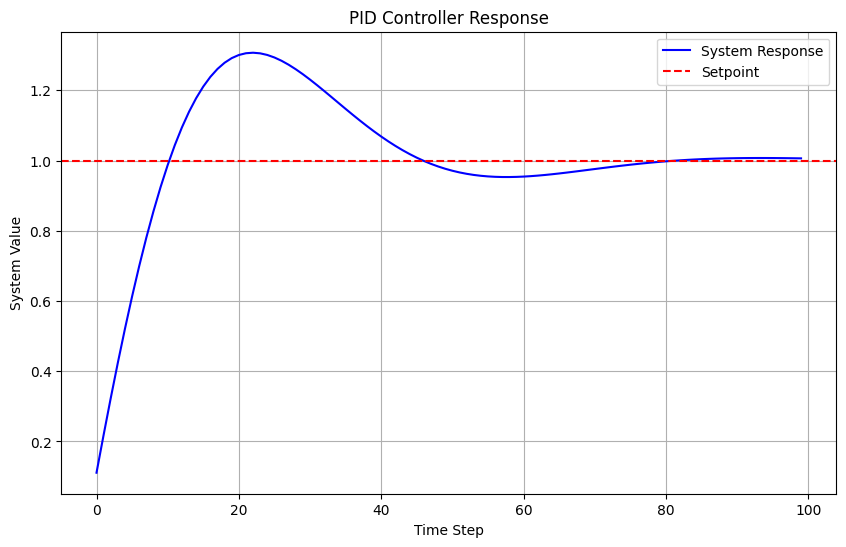

In [7]:
import numpy as np
import matplotlib.pyplot as plt

class SimplePIDController:
    """
    A basic PID controller for single-axis control.
    """
    def __init__(self, kp, ki, kd, target=0.0):
        """
        Initialize the PID controller with given gains and target value.

        Args:
            kp (float): Proportional gain.
            ki (float): Integral gain.
            kd (float): Derivative gain.
            target (float, optional): Desired setpoint. Defaults to 0.0.
        """
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.target = target
        self.error_sum = 0.0
        self.last_error = 0.0

    def compute(self, current_value):
        """
        Calculate the control signal based on the current error.

        Args:
            current_value (float): The current system value.

        Returns:
            float: Control signal to be applied.
        """
        error = self.target - current_value
        self.error_sum += error
        delta_error = error - self.last_error
        self.last_error = error

        return self.kp * error + self.ki * self.error_sum + self.kd * delta_error

# PID Tuning Test
def simulate_pid(kp, ki, kd, setpoint, initial_value, steps=100):
    pid = SimplePIDController(kp, ki, kd, target=setpoint)
    system_value = initial_value
    history = []

    for _ in range(steps):
        control_signal = pid.compute(system_value)
        system_value += control_signal * 0.1  # Simulate system response
        history.append(system_value)

    return history

# Parameters for testing
kp, ki, kd = 1.0, 0.1, 0.01
setpoint = 1.0
initial_value = 0.0
steps = 100

# Run the simulation
response = simulate_pid(kp, ki, kd, setpoint, initial_value, steps)
time_steps = np.arange(len(response))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(time_steps, response, label="System Response", color="blue")
plt.axhline(y=setpoint, color='red', linestyle='--', label="Setpoint")
plt.title("PID Controller Response")
plt.xlabel("Time Step")
plt.ylabel("System Value")
plt.legend()
plt.grid()
plt.show()
